In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import platform
from IPython.display import display, clear_output, HTML
from datetime import datetime
import pickle

from time import sleep
from tqdm.auto import tqdm

import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver import Firefox, ActionChains

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

START_TS = datetime.now()

In [2]:
from utils import get_all_elements, iou_xywh, screenshot, maximize_window

In [3]:
selenium.__version__

'3.141.0'

## Parameters

In [4]:
SITE_ROOT = 'https://jdi-testing.github.io/jdi-light/'
DRIVER_FILE = 'geckodriver.exe'
LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False


In [5]:
os.path.isfile(DRIVER_FILE)


True

In [6]:
if platform.system()=='Windows':
    
    if os.path.isfile(DRIVER_FILE):
        path = set(os.environ['PATH'].split(';'))
        path.add(os.getcwd())
        os.environ['PATH'] = ';'.join(path).strip(';')

In [7]:
print(os.environ['PATH'])

C:\minishift;C:\Program Files\Docker\Docker\resources\bin;D:\Anaconda3;C:\Windows\System32\WindowsPowerShell\v1.0;D:\Anaconda3\condabin;D:\Anaconda3\envs\py37-torch\Library\mingw-w64\bin;C:\VSCode\bin;C:\ProgramData\DockerDesktop\version-bin;C:\Users\vyach\AppData\Local\Microsoft\WindowsApps;D:\Anaconda3\envs\py37-torch\Library\usr\bin;C:\Windows\System32\Wbem;C:\WINDOWS\System32\Wbem;d:\anaconda3\envs\py37-torch\lib\site-packages\llvmlite\binding;C:\cuda\bin;D:\Anaconda3\Library\usr\bin;.;D:\Anaconda3\Library\mingw-w64\bin;C:\Windows;C:\Anaconda3\Scripts;D:\Anaconda3\envs\py37-torch\Library\bin;C:\WINDOWS;C:\openshift;C:\Program Files\Git\cmd;D:\Anaconda3\envs\py37-torch\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\libnvvp;C:\Anaconda3;C:\cuda8\bin;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\Program Files\NVIDIA Corporation\Nsight Compute 2019.4.0;C:\Windows\System32\OpenSSH;C:\ProgramData\chocolatey\bin;C:\WINDO

## Create driver (HEADLESS={True|False})

In [8]:
options = selenium.webdriver.FirefoxOptions()
options.headless = HEADLESS

In [9]:
driver = Firefox(executable_path = os.path.join(os.getcwd(),'geckodriver.exe'), options=options)
driver.get(SITE_ROOT)

In [10]:
driver.get_window_position(), driver.get_window_size(), driver.title

({'x': 4, 'y': 4}, {'width': 1366, 'height': 768}, 'Home Page')

In [11]:
re.findall('<[A-Za-z]+ [^<>]*>', driver.page_source)

['<html lang="en">',
 '<meta charset="utf-8">',
 '<meta http-equiv="X-UA-Compatible" content="IE=edge">',
 '<meta name="viewport" content="width=device-width">',
 '<link rel="stylesheet" href="bootstrap/css/bootstrap.min.css">',
 '<link rel="stylesheet" href="css/uui-all.css">',
 '<link rel="stylesheet" href="css/custom-styles.css">',
 '<link rel="stylesheet" href="fonts/font-awesome/css/font-awesome.min.css">',
 '<link rel="stylesheet" href="css/lib/components/jquery.mCustomScrollbar.css">',
 '<script src="js/lib/jquery-1.11.1.min.js">',
 '<script src="js/lib/components/jquery.mCustomScrollbar.concat.min.js">',
 '<script src="js/lib/jquery.cookie.js">',
 '<script src="bootstrap/js/bootstrap.min.js">',
 '<script src="js/uui-core.min.js" type="text/javascript">',
 '<script src="js/utils.js" type="text/javascript">',
 '<script src="js/lib/html5shiv.js">',
 '<script src="js/lib/respond.min.js">',
 '<div class="uui-header dark-gray">',
 '<nav role="navigation">',
 '<div class="sidebar-togg

In [12]:
[(e.tag_name, e.is_displayed(), e.id) for e in driver.find_elements_by_xpath('//*') if e.tag_name == 'span']

[('span', False, '6983b17e-07f5-42ab-acbd-3492114ab3ac'),
 ('span', True, '500c41cf-cb8d-4b8f-b2ef-f8591fd6c9e3'),
 ('span', True, '8eab3c2f-76fc-414c-bc3e-ec33cbe7a4d0'),
 ('span', False, 'f5d4fc88-ad3f-431a-87ce-88e969700ad1'),
 ('span', True, '825f1240-b8b8-4d4c-b61f-e884e4b24c90'),
 ('span', False, 'a7166ec5-c94e-4149-b80b-570f7efb2891'),
 ('span', False, '336cc94c-094f-493a-8451-1d070204f435'),
 ('span', False, 'e6809a2d-7173-4c0e-a24c-a017082dae4e'),
 ('span', True, '97942295-67cd-49ed-a0d8-9f577deda44c'),
 ('span', False, '12ac3a4f-87d8-4950-be82-d215981759b6'),
 ('span', False, 'b131e965-d274-44c7-9ca8-7d4cb96be412'),
 ('span', True, '95ef7726-be5f-4bb1-b1b4-a7e8ede5fbbd'),
 ('span', True, 'e69caedb-6377-4d6b-95c5-88a72695ebef'),
 ('span', True, '2949ab8c-8f6a-4da1-b622-f480745bbb59'),
 ('span', False, '4c9b7169-d591-49b3-88a3-5cb3118e4f0b'),
 ('span', False, '83fb0cf7-20e0-4a12-9703-e31cbafcff25'),
 ('span', False, '62ed3ad5-2e24-4c59-b96c-44e6b6166c5c'),
 ('span', False, '126

In [13]:
driver.close()

In [14]:
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/df', exist_ok=True)
os.makedirs('dataset/annotations', exist_ok=True)
os.makedirs('dataset/html', exist_ok=True)


## Setup (init web driver, login)

In [15]:
def setup_web_driver():
    
    options = selenium.webdriver.FirefoxOptions()
    options.headless = HEADLESS 
    driver = Firefox(executable_path = os.path.join(os.getcwd(),'geckodriver.exe'), options=options)
    driver.get(SITE_ROOT)
    
    driver.find_element_by_id("user-icon").click()
    driver.find_element_by_id("name").send_keys(LOGIN)
    driver.find_element_by_id("password").send_keys(PASSWORD)
    driver.find_element_by_id("login-button").click()
    sleep(WAIT_TIME_SECONDS)
        
    return driver
    

Window maximized
Number of discovered elements: 228


  0%|          | 0/228 [00:00<?, ?it/s]

,parent_id,element_id,tag_name,x,y,height,width,displayed,enabled,selected,text,is_hover,base64png_before_hover,base64png_after_hover,tag_class
0,None,69b9c719-199d-4e97-8875-dd835621d7f7,html,0,0,1245.0,1332.000000,True,True,False,None,False,None,None,
1,69b9c719-199d-4e97-8875-dd835621d7f7,39404081-f2f8-4d88-9619-049540447a90,head,0,0,0.0,0.000000,False,True,False,None,False,None,None,
2,39404081-f2f8-4d88-9619-049540447a90,34665498-e64f-483a-9350-0a66410f0aac,meta,0,0,0.0,0.000000,False,True,False,None,False,None,None,
3,39404081-f2f8-4d88-9619-049540447a90,20fc449e-d245-4e62-920b-2aaa384d1a11,title,0,0,0.0,0.000000,False,True,False,Home Page,False,None,None,
4,39404081-f2f8-4d88-9619-049540447a90,328d8905-e917-40c4-ba71-d66579203f14,meta,0,0,0.0,0.000000,False,True,False,None,False,None,None,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,7417ca46-8ec3-4305-83a2-6df84475eda8,e6765416-7cb7-4f8b-a482-83b64c3f1404,li,1230,1280,15.0,2.899994,True,True,False,None,False,iVBORw0KGgoAAAANSUhEUgAAAAIAAAAPCAYAAADOKB76AA...,iVBORw0KGgoAAAANSUhEUgAAAAIAAAAPCAYAAADOKB76AA...,
224,7417ca46-8ec3-4305-83a2-6df84475eda8,2cd6949e-3ecc-4025-babe-b600d056f257,li,1248,1280,15.0,64.100006,True,True,False,None,True,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,
225,2cd6949e-3ecc-4025-babe-b600d056f257,1f7256e1-f68b-47ca-abc1-5edd9a548773,a,1248,1280,15.0,64.100006,True,True,False,Report a bug,True,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,iVBORw0KGgoAAAANSUhEUgAAAEAAAAAPCAYAAABUZ8lnAA...,
226,7924693e-e0a7-4268-a419-3bdb3a887afd,caf70889-3cfc-4ff4-a3f4-53bf469ba299,script,0,50,0.0,0.000000,False,True,False,"\n UUI.Vertical_Menu.init({""open"": true...",False,None,None,


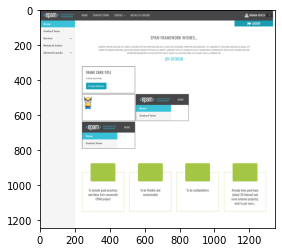

In [16]:
with setup_web_driver() as driver:
    maximize_window(driver=driver)
    plt.imshow(screenshot(driver, save_to_file='dataset/images/login.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/login.parquet')
    with open('dataset/html/login.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()
    
    
display(elements_df)


In [17]:
elements_df.tag_class.unique()

array(['', 'uui-header dark-gray', 'sidebar-toggle-box blue',
       'sidebar-tooltip', 'fa fa-reorder', 'epam-logo',
       'uui-navigation nav navbar-nav m-l8', 'dropdown',
       'dropdown-toggle', 'caret', 'dropdown-menu',
       'uui-navigation navbar-nav navbar-right',
       'dropdown uui-profile-menu open', 'profile-photo',
       'dropdown-menu dropdown-menu-login',
       'form-horizontal login hidden', 'form-horizontal-pad',
       'form-group form-group10', 'col-sm-3', 'col-sm-9',
       'uui-form-element', 'login-txt hidden',
       'uui-button dark-blue btn-login', 'fa fa-sign-in', 'logout',
       'fa fa-sign-out', 'search', 'icon-search', 'search-active hidden',
       'search-title', 'icon-search active', 'search-field', 'wrapper',
       'uui-side-bar mCustomScrollbar _mCS_1 mCS_no_scrollbar',
       'mCustomScrollBox mCS-light mCSB_vertical mCSB_inside',
       'mCSB_container mCS_y_hidden mCS_no_scrollbar_y', 'sidebar-menu',
       'active', 'menu-title', 'fa fa-car

# Save pages & screenshots

- ## HTML 5

Window maximized
Number of discovered elements: 662


  0%|          | 0/662 [00:00<?, ?it/s]

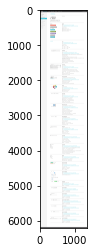

In [18]:
with setup_web_driver() as driver:
      
    driver.find_element(By.LINK_TEXT, "Elements packs").click()
    driver.find_element(By.LINK_TEXT, "HTML 5").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/html-5.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/html-5.parquet')
    with open('dataset/html/html-5.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()
    



- ## Contact form

Window maximized
Number of discovered elements: 336


  0%|          | 0/336 [00:00<?, ?it/s]

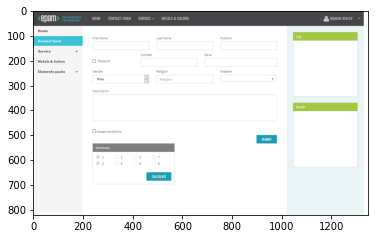

In [19]:
with setup_web_driver() as driver:
      
    driver.find_element(By.LINK_TEXT, "Contact form").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/contact-form.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/contact-form.parquet')
    with open('dataset/html/contact-form.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()
    


- ## Mobile and HTML 5

Window maximized
Number of discovered elements: 647


  0%|          | 0/647 [00:00<?, ?it/s]

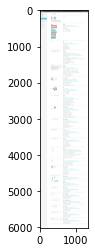

In [20]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("Mobile and HTML 5").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/mobile-and-html-5.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/mobile-and-html-5.parquet')
    with open('dataset/html/mobile-and-html-5.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()
    


- ## Bootstrap

Window maximized
Number of discovered elements: 1095


  0%|          | 0/1095 [00:00<?, ?it/s]

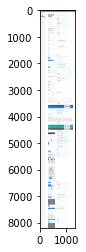

In [21]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("Bootstrap").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/bootstrap.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/bootstrap.parquet')
    
    with open('dataset/html/bootstrap.html', 'w') as f:
        f.write(driver.page_source)
        f.flush()
    
  


- ## React Ant

Window maximized
Number of discovered elements: 700


  0%|          | 0/700 [00:00<?, ?it/s]

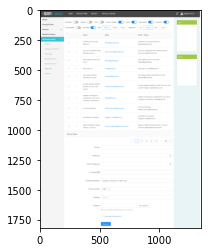

In [24]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("React Ant").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/react-ant.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/react-ant.parquet')

    with open('dataset/html/react-ant.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    
  


- ## Angular

Window maximized
Number of discovered elements: 6447


  0%|          | 0/6447 [00:00<?, ?it/s]

 element: header <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="02882be2-f825-408c-a1da-b3b00905b302")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="90cc28fd-53b2-42fb-bc19-f4388d7996e4")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="68f21634-42bc-4239-85af-bf940f439d8e")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5da644f8-eaf4-4ab1-b7f7-050829731ab0")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="52c06e34-194e-42bd-9fbe-919ba97e4a58")>
 element: h2 <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="6ec9aba7-63fe-4568-8486-

 element: path <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="0c7f2b72-5015-4905-a055-16835c79ede7")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="28931400-815a-46d9-b410-842cb29e310e")>
 element: mat-checkbox <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c33b7f90-d431-4052-941b-80ca999b692e")>
 element: label <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="029372f4-c9e3-4906-8761-d8e40af0814e")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="3397b3af-6a47-42c5-a102-7b646381f568")>
 element: input <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="8fe0625a-43

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d0a9a220-a04b-4b81-88a9-a0081bfc41d7")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="3f3aa7d1-2787-4ef0-ae67-49915039cae5")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="fb3ccaba-8922-44ba-9437-0db029cef6b9")>
 element: input <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="2845f39b-80e9-46bb-b924-78fed67a849f")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ee6fe071-2d14-4263-a2a3-9b21ad7ef78d")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="94c1bc6e-062c-47db-9de

 element: mat-label <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="720c5070-11f8-4f10-baf9-a5c2aa551ae5")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5c1b804a-270d-4cf3-bd21-16113502e8da")>
 element: li <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="fb394fb9-285f-4aaa-ab89-26bf65ade9f3")>
 element: button <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="26ca7bf7-0beb-4ea1-86a2-b23b5f9566a2")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="51603ad9-68a5-448c-bdff-0cccacf1ea5e")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="270237b6-b01c-46

 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a98bec8b-de15-473f-8de2-4df083fb4558")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="885a2571-8f0a-4418-9a1a-eeb7a9beb807")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="032bf1c6-f390-4d51-82f7-e9d1e025ac70")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="0b4a6237-bfee-4032-869c-cc6c622cf606")>
 element: snack-bar-component-example <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d5306a1e-7549-459c-a79e-78f73b40d2e5")>
 element: h2 <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="f7

 element: mat-form-field <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="2582fda4-062d-49b9-a7d3-afbd1c60bd32")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="7c20156e-e827-4399-8590-cfb0a808a6ed")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="df1566e7-2d61-4636-8dd2-16b00af8ad55")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5a0c29f8-1db1-4492-a34b-fce97be7c33b")>
 element: mat-select <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="3b3084d5-6e0d-4d1b-bbee-037abd0651a4")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="9b2495e2

 element: input <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ae2d9bf3-6b02-4e25-a321-a744c764dc79")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="47945580-a399-4243-8d66-769def25eda9")>
 element: label <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="51499514-5619-4114-a9a1-d0cb75da1b46")>
 element: mat-label <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="056dc73c-cf2c-4864-9579-d8f31a420b0e")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c2bf30e1-a445-4a98-8fc3-5f9a08909610")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="82beaf2c-d803-

 element: mat-checkbox <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="55d65c08-2bc0-47ff-a9a8-fc9c6354b9a7")>
 element: label <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ae5a3ed3-e4f7-4daa-8447-a6684df59c39")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b28fd75a-2eac-471d-bc71-093c083303b5")>
 element: input <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a3ed632a-816b-4b2e-8bd7-50d3391523bd")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="64cff1d1-9bc9-453e-ad98-52383f16a82e")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d7eddce9-d32a

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a1197970-377d-4628-b994-4fcb97d6c825")>
 element: tooltip-message-example <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="904b080b-2d83-45ea-a0be-fff07f48f6cf")>
 element: h2 <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="3619eeae-79c8-4ed1-be6a-2835c85cfeb7")>
 element: mat-form-field <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c7668ba9-8a0a-45e6-acb0-cfd6a6d2a2ef")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="75db05fd-8a99-413d-b785-2ee0851d26af")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", eleme

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="281ea15c-b06a-41f6-88e9-52d3a0661e3e")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="15d874c8-7e8e-4e51-a735-97eae57a9403")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="0f31b909-046b-428e-aa40-3bbd27ffa27e")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="69faf1df-7829-471c-9977-3913a9e66f0a")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="7f678cdf-0da1-4b72-9736-10d7daa9af78")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1080b110-e607-4014-9deb

 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="495abac2-9f1b-4ed1-9244-4cd421a65040")>
 element: label <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ff1418db-2e58-48e9-a609-b45ec268e839")>
 element: mat-label <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c4885715-8650-4b8b-a275-cdcdbe6a52aa")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="04e03243-9187-4a2c-af5f-9b47c4e6d198")>
 element: mat-form-field <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="28f71374-98a3-49cc-afd3-7fba07c1b0c0")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="f8e33

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="68a31784-6fad-42eb-a564-6ff776bdb921")>
 element: button <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1caf2c00-89fb-44bf-93f2-6496e07c5cf3")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="38034bfa-1421-43f6-a152-052aa53dea6c")>
 element: svg <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="fd539dff-8084-4d62-bcd3-0b72dc3c9de4")>
 element: path <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="8b63619a-d828-46c9-b2fa-6ab5947eb0c9")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="3da89bac-666b-46cc-be

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="230feca7-d366-486c-942f-0a2245293740")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b13d767a-1711-4c08-949c-3af3d97dc414")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="74eb549f-afcb-42ca-84c8-b3600e9f2863")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c90490d6-5b7f-49ae-aea1-2fab226cb5fe")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b26dd2c0-7ed4-41fa-befe-499f6ef72c78")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="66d5c46a-c1e0-4aba-8ada-e6

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="176bf846-1d03-463f-813e-6ef9829e4aec")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="cc8e4dc4-ee01-4019-87af-803f2f177a28")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="915035c9-65da-475e-8557-bb229a6df037")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="0ab5dde7-5f86-423a-9f74-3b7620d08de6")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1a8ec295-0456-4d6c-9dc5-ce5b62ae21b3")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="6eec1d33-d20e-456e-826c-c38569c

 element: a <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="15ccc5bf-bc3b-424e-b3c6-5438aebe94e7")>
 element: i <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="fa5dbda6-7549-4ed0-8cde-e484e9fc72cf")>
 element: table-basic-example <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ceb86a4d-a431-45d0-8c90-afd32ffe497c")>
 element: h2 <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5d00dd60-1f3f-4c8b-98f2-4c0f24c9093e")>
 element: a <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e4126979-3714-4288-b88c-0003c7be8973")>
 element: table <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="2237d62d-2abf-4

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="4f06db1c-08ac-4c1f-8cf4-107b34cfae80")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b9079752-6cb8-450f-8704-00891c9ee775")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e6d9d3e0-66db-4ae9-8f0a-2d9f40a6d82f")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="9f22332c-9fcd-471d-a5b0-99d833e5da93")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="570a3bc2-9736-4f76-8351-5d2e0b03c06e")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ecad12ef-f32f-4216-9fd7-ea29e1dd

 element: mat-row <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d8831db0-492b-4f12-a1cf-75656f5a90ae")>
 element: mat-cell <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="68b1bf8b-9dc1-4540-97f4-8e9e16626596")>
 element: mat-cell <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="29d1e141-5432-4fd6-b373-3ca1cb1f68de")>
 element: mat-cell <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1cccae0a-bfa1-49cb-88c1-bab6e8832e8d")>
 element: mat-cell <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="677ac8ee-d37d-4204-91f4-ce4941c364d5")>
 element: mat-row <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="0ae76065-b010-4da3-98f0-adf8138be33b")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="87c13de5-f51b-438e-86db-202dcc3693c4")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="350db7ac-9289-4b3d-9cfe-65d69466eddd")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1017b19c-6b96-47eb-a03a-4c51539c9256")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1804a52d-882f-48e7-a0d7-dfb1844489ab")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="74b74e00-4790-4fcd-9623-28df3a66

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="f9538bb6-552a-445d-a333-04340e7e4378")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="32efa33c-a856-41ea-a3fb-9cb2f1a8c28f")>
 element: table-expandable-rows-example <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="8d6e1032-9595-475a-a365-33702731f7de")>
 element: h2 <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="664fa6f7-2f06-4802-837c-7d008affffc5")>
 element: table <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="9ab4f979-199d-4988-af0b-bb6caffa8728")>
 element: thead <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d4cfab78-32d1-4721-a6d0-bd76a48ed187")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="bd7c509d-0198-4b0e-851f-c6180dccff12")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="afbbd958-d656-4763-ac34-0ce16abe1707")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a7f20e32-222e-4bc4-99ac-12021f097a78")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ba8c4918-a50a-435b-bea5-53c1747f12c8")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="827ce8d5-6d84-44bc-8835-bfff8948

 element: a <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="6d7bf5ab-7e3d-4f56-ae3b-e8f8c5ef53d3")>
 element: mat-form-field <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="360b44df-dda8-4887-b647-f260f942fc3b")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="6ca132a4-edeb-4e84-b690-f66c713310cc")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="561fc2cb-82bb-4593-9ee4-629f904c8ba2")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="dc6923fc-c1e5-4b24-a3bf-b59dc7a7a5b3")>
 element: input <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="49924e0f-617b-4

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d9bc3c16-ecc0-4b13-820c-26161d2d7eda")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e7026282-367b-48a1-96fb-6a527332eda4")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a4eb5321-a178-4690-8564-753a06d61fdb")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5d9f4eba-c510-406c-a7e7-8569d6ff4db7")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="71e99f9b-ce24-47a4-9e92-1bbf30f5a3c0")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c2ae1d8c-b3d1-4554-a5e6-1bdbc561

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="6ba41ab2-1277-4448-9091-7f6330b9234f")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="7b21d933-eb81-480a-8976-a57c68d7c218")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1453efe2-415d-4507-9a15-a7dc176aed7d")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="bac80e85-d004-4b8b-8909-8be64886c142")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="11db2db1-aeca-4062-b1b6-3e6e29688935")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a1a089f5-0763-4871-b7bd-d3f75a6e

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1ac5003f-d559-4bff-ade7-d73a90c0d67c")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="bcf5b99e-910d-4ff1-8c84-35f912a5a8a7")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="7abb7854-a5fa-4ddf-a21d-5099cacf6b4d")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="be4409cf-a764-4709-91c5-6332796a4d08")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="0ae00ff0-8bcc-47e4-9bdd-2969db7357b1")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c5c2ab69-f1c6-4669-8dd1-f2

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="26aa2aad-527a-4efb-a83f-0924be4255bf")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="49b965ed-b57b-499d-848d-b55afd1e4e91")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="6a203b54-bcf4-4d07-8106-70b02527ba2e")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="15c858cf-8ce9-45dc-a2fc-987c401a2f08")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="2b85e28a-dbdf-4c93-aa5d-615e8840cab7")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e0974503-dc71-4c4e-a3f3-35296105

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="9ec5e716-1105-4aed-a3ee-13f39ef80a7e")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="7839749d-e481-4c6b-90dc-cf67423df8de")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a034867f-e4c8-4cdc-9ec9-5ac7a3845e7f")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="363ddcdf-8aed-4ed6-a04e-cbec0b1645e3")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d64cd8f6-8772-4b60-ac96-9e9beff2cba4")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="25b2fc88-26f1-4e79-b2a3-4b4aeef1

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="fb85f583-9e55-408b-b03f-0820fc61e95f")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="709524a1-fa47-4506-900e-fc843e39e702")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ee7575c9-0ca7-4e84-8ed3-75be6f79b06f")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="bb406966-1a8a-4954-ba46-74c1ee812772")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="99a38155-c263-4368-b42d-013e761705dd")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b029dd30-a84e-4c44-9c6f-1ea8c405

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="0a33fa96-5a83-4b0a-a859-3eb8f2b2deda")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="dd70575e-f0b2-446a-89a2-b04d0b87600e")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="71ef03b3-51d8-4db1-8ae8-1357201175ac")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="6c6d306f-1724-4cc0-a8bf-75d5d493a131")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e0994820-89b8-4ef2-9c5a-c37a99ab8aa1")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="58073314-f005-471f-8f54-102ffb28

 element: mat-paginator <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="996044d7-34ac-4719-a7dc-33c90162e377")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="19698fe6-239b-4087-8031-cdfa92faea77")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="6d3321c8-dd68-42d7-81a6-ce96c57af606")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="700d95c9-e6ca-4963-bce5-b276a21db619")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="38dfb407-316d-455a-92f7-000205ea0c2d")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a6ec2571-319d-47

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="8fcdf660-6f4a-433d-8e27-5289a2f16edd")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="cebbaa48-0ed7-4064-9244-ffb33841c190")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="fe12198e-e3a8-459b-921d-ab6192e955f5")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="dbae32ed-6135-43e0-a150-35b01f8b642a")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="170625a0-72a9-49d2-8388-e59abbddbb7f")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="aed53ef0-e8d4-4c7e-8a53-f623155c

 element: mat-label <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b596e4f1-b7ce-4c0b-99f5-0f4652aa392b")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="4503c3d8-3811-4a6b-a101-2081e6350934")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="9e7656dd-3655-4429-8abe-939a19e166a6")>
 element: table <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="9c453688-f3fc-429b-966f-18eb1a3fe393")>
 element: thead <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="9b003136-d965-48b6-8f42-2b13be2ca871")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c7070e4d-ade4-4e

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e99a70a8-7730-4d69-9ae0-5df876ac15e5")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="290d8387-f3c5-4c43-9e5c-0864fa2ef2e5")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="cb41542c-381b-469d-8bde-ccec8dc52fe6")>
 element: button <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="7fe1aa43-70e3-4e6b-9044-ece6b7654236")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="f0631d41-3b23-4876-9089-1b3dba792cd2")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="31239d4d-5325-4c85-be35-

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="6ed1da8d-3f5b-4f5d-ac2d-2dfc15ec25d8")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="77969f16-e101-4498-8769-e1f847d5cccb")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="31c4597c-090c-4221-b2ce-d2ec9ed779cd")>
 element: mat-select <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e2829a74-22cd-47af-b49a-56c420a95fb3")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="66c48d74-3fbe-4432-9edc-602caddb945f")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5eef02d1-ba39-43a5-

 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1ef0faaa-4c1e-4abc-ad02-7be10bc6692c")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ac66946a-8e8e-46c4-9a92-1eb380e5428b")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="72599963-47fb-42a0-a31c-62f47aeb70be")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a1c5f64c-8473-4903-89e2-c7d279a020cc")>
 element: tbody <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="09502fa6-329b-48c2-96e7-f598cfdfb487")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="7ee7416a-93ce-4492-bbfc-4884e

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="f18dfdc5-5c0b-4655-943c-36fae93b47f8")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="185682b2-05c7-4154-8bdf-26ee109384bb")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="edaf414b-420a-48a1-815a-2b37e49eb730")>
 element: mat-form-field <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="2ab7d404-76f6-4c05-a2ce-3eb53643a95e")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b2aaaf18-6064-4758-a55d-b637c6a054d4")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="cd125d1b-1685-4

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d458088c-7a35-46af-9b18-09e37628ae08")>
 element: button <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="8a85b45e-f06e-4788-bf6e-a9a623419851")>
 element: span <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="68d09e90-049a-4225-8fa5-8c8dca70be92")>
 element: svg <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="568203a7-34c0-41be-b86d-020ad9af2bda")>
 element: path <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d5d9ddb8-308e-44d1-be96-0b3e9593e5b8")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b965cb37-9ed6-45e1-96

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="cd7e45fd-78b5-4c20-b7b4-b44c09bbb1ee")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="cd152695-3915-4a28-abb9-2ecff3276ada")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d7409bae-f089-4295-83cb-6d1a0b609e2a")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="fc696a51-d108-420d-be0d-31feec7f9ab7")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="3f726bf5-0d2a-4ca6-b8ce-4fa36cfcfdf6")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="f7a9b70f-3997-4441-ad9c-d7c65281

 element: table <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d501ff96-d4ba-4ff0-93f4-d4965afc26af")>
 element: thead <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="72dd769b-7fbd-4e0e-ac02-67b38561ab30")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="9e9169c9-c13c-49e1-ba2c-301ea6376a1d")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b2b7bdbf-9d1d-48d2-941c-e1380de2125a")>
 element: mat-checkbox <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ffa986f8-897a-4717-8f82-78c0426464de")>
 element: label <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c6de4dec-0471

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="38b8fdd9-bb9d-479c-8329-25ccb52813cf")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="787c34c8-6277-48b3-9b2c-cde55d342b9e")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="49136502-fcd6-49af-affd-fa4a907515cc")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="2fd22245-27f1-4fd4-af9c-0ed0be691c42")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="309872a4-33fd-43b0-a906-e1fdea81ccbf")>
 element: mat-checkbox <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="db220aea-87c1-448d-ac6

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="524176f4-e094-42a1-866c-88af5b97242c")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="352eec63-407d-4b8c-98db-ff25fc8c0b61")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="8e14ab8f-70bf-4349-a055-fe58698c3064")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="7ac3f0e2-c4d7-49c6-8059-d6091c1fff0e")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c314b335-d808-4469-87b7-bede1bccf407")>
 element: mat-checkbox <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ab6405b3-c393-423d-8ac

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="f8219f9d-9f43-4a49-a099-2d3d45f33fad")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b8e1a018-67ce-4789-b7be-0943f256768a")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="60c9247b-da70-423e-b0e9-bbbc1cfbc032")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="428a9cc7-07a6-419b-b464-fe9a8bc985e2")>
 element: table-sorting-example <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="58892bf7-221a-4c75-9fa8-35ef4f2aeb2b")>
 element: h2 <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="605a9627-8e6

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b7da4865-8f1a-474c-8b9d-98262c248edb")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ff3a14a0-7165-45c3-a16c-22211ed24b15")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ace595c8-2391-4b5f-be13-ff2de49415a0")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d2674085-1750-4bde-8416-46eef98925db")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a403897f-ddff-4445-b13d-6acd46df06b9")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="de5341b3-a1b4-419d-a18c-a97

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="810d4696-6f64-4ee2-b66c-39fbaaff7591")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="8e3f7737-f799-4d9a-888b-1cc52e88ccf6")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ba7689d1-8e91-450c-b7c1-a05cf4852d4f")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="a2c9dcf2-3cf3-4503-8449-3129005f530a")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1187b1ea-974a-45be-afb7-c368c7be2703")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5522beb9-1412-4b51-9066-eaca9daa

 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e68badbf-02ad-48e5-9634-cff18963febe")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d93449fe-3221-4ad3-9021-9bbe044e59b6")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="0ea600ac-eb7b-46f2-9a34-577fd0b16c10")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="944be08a-8721-4e6b-859a-715fac06efb3")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="72b81727-d310-4a4c-9aa9-25b0fc302012")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="dfa26f57-2aa0-43fc-8bf8-ebb7f706

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="8cc865b4-7c90-47a1-acd0-efbd1d0769a8")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="1752e242-d0c9-4b52-a4a4-83e4ac0d5a96")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="0f74a8a1-f619-4b40-a804-363394898a86")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="4352c423-7c51-4aed-a43d-36b16f0be048")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="59ea7514-4673-4fcd-8be0-cfbd480cd721")>
 element: mat-icon <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ecce6a57-dc63-4aa1-bac0-e7

 element: mat-icon <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="dc69071d-e8c2-4d2b-b8e3-060e93bb78dd")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5928429f-b8fe-4be2-b0b8-261d9d6c4141")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5572371c-9f84-4370-86f2-4212369b4e0d")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="34b47e7a-26da-4dbb-8f9a-772235946e4b")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="143fc422-6b23-4923-bcc1-0836b5f18c6c")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ad79a01e-ae31-4a84-bcca-77

 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="68b892c6-024d-4630-88ba-a86ccc9783cc")>
 element: table <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="339b785f-602e-4417-a340-1bf47025f92b")>
 element: thead <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d3a368ce-642f-4d1f-b31e-17fd8e38f8de")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="03263a79-a2ed-4a15-aff2-a23def8b3a78")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="63644412-110c-4873-859f-d06babc49cc8")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="279a3d18-00dc-4ae3-815c-b

 element: a <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="c368e7b2-0287-437f-944a-4b5aba0b35ef")>
 element: div <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="565aa903-000b-4def-abe9-777805a03a2d")>
 element: table <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="f75ec22a-463f-4c4b-840c-582e2ccf45d0")>
 element: thead <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="4427d643-39d1-4707-aee4-fc79c409b47b")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e2071552-38ec-421c-9dc3-7f09557c033b")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="187d10db-6471-4858-b8a9-cc

 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="4b04c9b8-4407-48e1-a57a-d3127517443a")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="397e8743-9ea0-4ecf-bc8d-f0f94fd1a9e4")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="76d25f7a-1c6a-4324-b37f-7f008920ecd1")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="8e4afbf4-02f0-4fa1-9dcb-addf88bc6f34")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="b799e4c3-1b28-4933-acd5-4156cef7cc24")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5595cc1f-8474-4acc-9dce-c5107ec3

 element: thead <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="30e80456-51e2-4eab-8cd0-bb3cb1afe317")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="bbaf90b7-62db-4f8b-b314-d54366050657")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="4dfa319a-ca50-4b1f-9138-8873fde6dc80")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="5e71bd86-e417-45a3-9f98-690947139b9e")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="800effea-8100-41bb-af49-c43163da489a")>
 element: th <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="65322663-b82a-4fdc-9bd8-ce4e5

 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ed99ec4e-57aa-4f01-a6ea-539ff96af453")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="f69f9aca-5c8e-4dd5-8113-0c0357cde9a6")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="d8c31502-2d0f-499b-afc6-78df229b214f")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="e003b8fc-c01a-49ea-be92-c24d2e20848b")>
 element: td <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="ce7efb1e-7cd8-435d-aa76-65080c8abc73")>
 element: tr <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="61857183-59d7-4cf6-919a-c85c2fef7fff", element="eeb738ae-51dd-454a-92bd-6a47d419

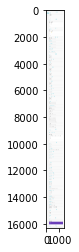

In [25]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Elements packs").click()
    driver.find_element_by_link_text("Angular").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/angular.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/angular.parquet')
    
    with open('dataset/html/angular.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Metals & Colors

Window maximized
Number of discovered elements: 373


  0%|          | 0/373 [00:00<?, ?it/s]

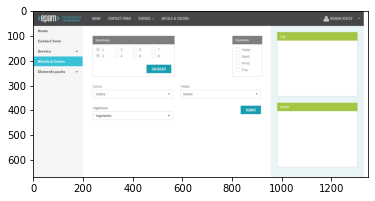

In [26]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Metals & Colors").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/metals-and-colors.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/metals-and-colors.parquet')
    
    with open('dataset/html/metals-and-colors.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Support

Window maximized
Number of discovered elements: 284


  0%|          | 0/284 [00:00<?, ?it/s]

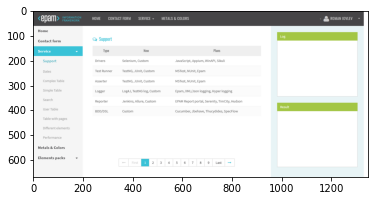

In [27]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Support").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/support.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/support.parquet')
    
    with open('dataset/html/support.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Dates

Window maximized
Number of discovered elements: 313


  0%|          | 0/313 [00:00<?, ?it/s]

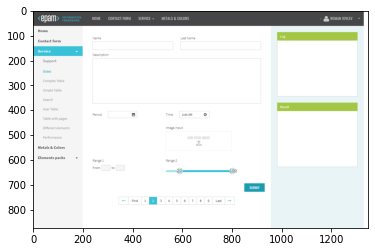

In [28]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Dates").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/dates.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/dates.parquet')
    
    with open('dataset/html/dates.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Complex Table

Window maximized
Number of discovered elements: 423


  0%|          | 0/423 [00:00<?, ?it/s]

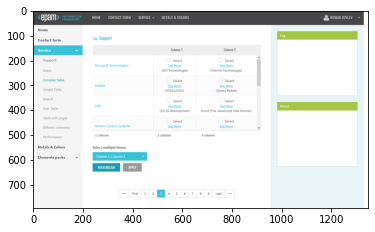

In [29]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Complex Table").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/complex-table.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/complex-table.parquet')
    
    with open('dataset/html/complex-table.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Search

Window maximized
Number of discovered elements: 294


  0%|          | 0/294 [00:00<?, ?it/s]

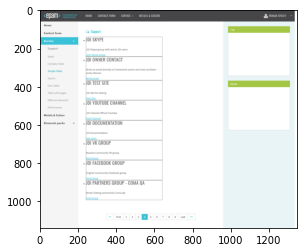

In [30]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Search").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/search.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/search.parquet')
    
    with open('dataset/html/search.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / User Table

Window maximized
Number of discovered elements: 366


  0%|          | 0/366 [00:00<?, ?it/s]

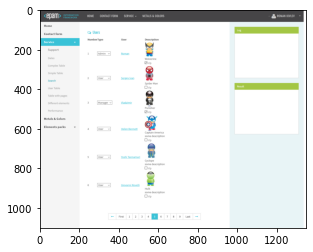

In [31]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("User Table").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/user-table.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/user-table.parquet')
    
    with open('dataset/html/user-table.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Table with pages

Window maximized
Number of discovered elements: 309


  0%|          | 0/309 [00:00<?, ?it/s]

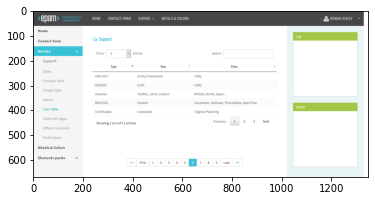

In [32]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Table with pages").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/table-with-pages.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/table-with-pages.parquet')
    
    with open('dataset/html/table-with=pages.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Different elements

Window maximized
Number of discovered elements: 289


  0%|          | 0/289 [00:00<?, ?it/s]

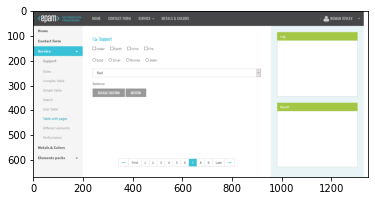

In [33]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Different elements").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/different-elements.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/different-elements.parquet')
    
    with open('dataset/html/different-elemants.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


- ## Service / Performance

Window maximized
Number of discovered elements: 2672


  0%|          | 0/2672 [00:00<?, ?it/s]

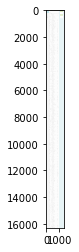

In [34]:
with setup_web_driver() as driver:
      
    driver.find_element_by_link_text("Service").click()
    driver.find_element_by_link_text("Performance").click()
    maximize_window(driver=driver)
    sleep(WAIT_TIME_SECONDS)
    
    plt.imshow(screenshot(driver, save_to_file='dataset/images/performance.png'))
    elements_df = get_all_elements(driver=driver)
    elements_df.to_parquet('dataset/df/performance.parquet')
    
    with open('dataset/html/performance.html', 'wb') as f:
        f.write(driver.page_source.encode())
        f.flush()
    


In [35]:
print('Elapsed time:', datetime.now() - START_TS)

Elapsed time: 3:24:46.420247
